This notebook plots the solutions. You can actually plot the progress while the solver is running to see if it makes sense.

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys, os
sys.path.insert(0, '../source')
import numpy as np
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
from params import rho_i, rho_w, g, delta, eta
from scipy.interpolate import griddata
from matplotlib.path import Path

In [2]:
#choose which results to load
results_name = '../results/example'

t = np.load(results_name+'/t.npy')
nodes_x = np.load(results_name+'/nodes_x.npy')
nodes_z = np.load(results_name+'/nodes_z.npy')
dofmap = np.load(results_name+'/dofmap.npy')

# load results and reorder dof's to the serial ordering
u = np.load(results_name+'/u.npy')
w = np.load(results_name+'/w.npy')
p = np.load(results_name+'/p.npy')
t = np.load(results_name+'/t.npy')

xh = np.load(results_name+'/xh.npy')
h = np.load(results_name+'/h.npy')

xs = np.load(results_name+'/xs.npy')
s = np.load(results_name+'/s.npy')

divuh = np.load(results_name+'/divuh.npy')
divus = np.load(results_name+'/divus.npy')

lapw = np.load(results_name+'/lapw.npy')


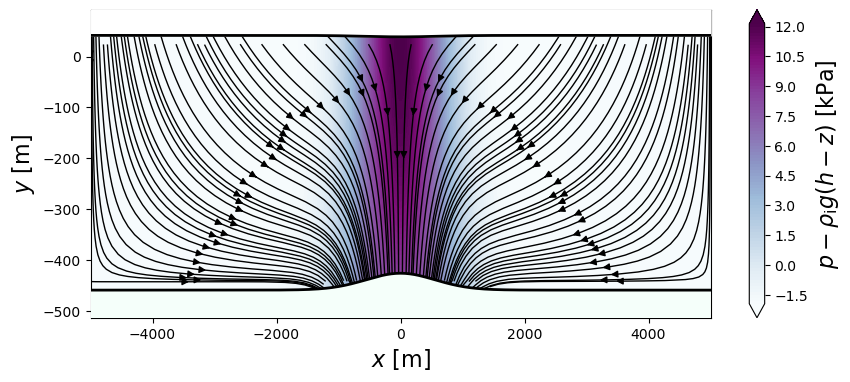

In [3]:
# timestep index for plotting 
i = -1

# ice surface
h_int = np.interp(nodes_x, xh[i], h[i])

# cryostatic pressure
p_cryo = rho_i*g*(h_int-nodes_z[i])

# triangulation of domain
triang = Triangulation(nodes_x,nodes_z[i],dofmap)

# interpolation for streamplot 
xi = np.linspace(nodes_x.min(), nodes_x.max(), 200)
zi = np.linspace(nodes_z[i].min(), nodes_z[i].max(), 200)
X, Z = np.meshgrid(xi, zi)
u_interp = griddata((nodes_x, nodes_z[i]), u[i]*3.154e7, (X, Z), method='linear')
w_interp = griddata((nodes_x, nodes_z[i]), w[i]*3.154e7, (X, Z), method='linear')
max_speed = np.nanmax(np.sqrt(u_interp**2 + w_interp**2))

pad = 50
plt.figure(figsize=(10,4))
c = plt.tricontourf(triang,(p[i]-p_cryo)/1e3,cmap='BuPu',levels=100,extend='both')
plt.streamplot(xi, zi, u_interp/max_speed, w_interp/max_speed, color='k', linewidth=1,broken_streamlines=False)
plt.fill_between(xs[i],s[i]-10*pad,y2=s[i],facecolor='mintcream',zorder=100)
plt.fill_between(xh[i],h[i],y2=h[i]+10*pad,color='w',zorder=100)
plt.plot(xh[i],h[i],'k-',linewidth=2,zorder=101)
plt.plot(xs[i],s[i],'k-',linewidth=2,zorder=101)
plt.ylim(s.min()-pad,h.max()+pad)
plt.xlim(xh.min(),xh.max())
plt.xlabel(r'$x$ [m]',fontsize=16)
plt.ylabel(r'$y$ [m]',fontsize=16)
cbar = plt.colorbar(c)
cbar.ax.set_ylabel(r'$p-\rho_\mathrm{i}g(h-z)$ [kPa]',fontsize=16)
plt.show()
plt.close()

In [4]:
xi = np.linspace(nodes_x.min(), nodes_x.max(), 500)
zi = np.linspace(nodes_z[i].min(), nodes_z[i].max(), 500)
X, Z = np.meshgrid(xi, zi)
lapw_interp = griddata((nodes_x, nodes_z[i]), lapw[i], (X, Z), method='linear')

In [5]:
h_int = np.interp(xi, xh[i], h[i])
s_int = np.interp(xi, xs[i], s[i])
H = h_int-s_int
H_e = -s_int*(rho_w/rho_i)

In [6]:
lapw_zint = 0*xi
dz = np.abs(zi[1]-zi[0])
for j in range(xi.size):
    resmask = (Z[:,j]>=s_int[j])&(Z[:,j]<=h_int[j])
    lapw_zint[j] = np.trapezoid(lapw_interp[:,j][resmask],dx=dz)

In [7]:
div_diff = np.interp(xi, xh[i], divuh[i])-np.interp(xi, xs[i], divus[i])
R_est = (div_diff + lapw_zint)*(eta/(rho_i*g))

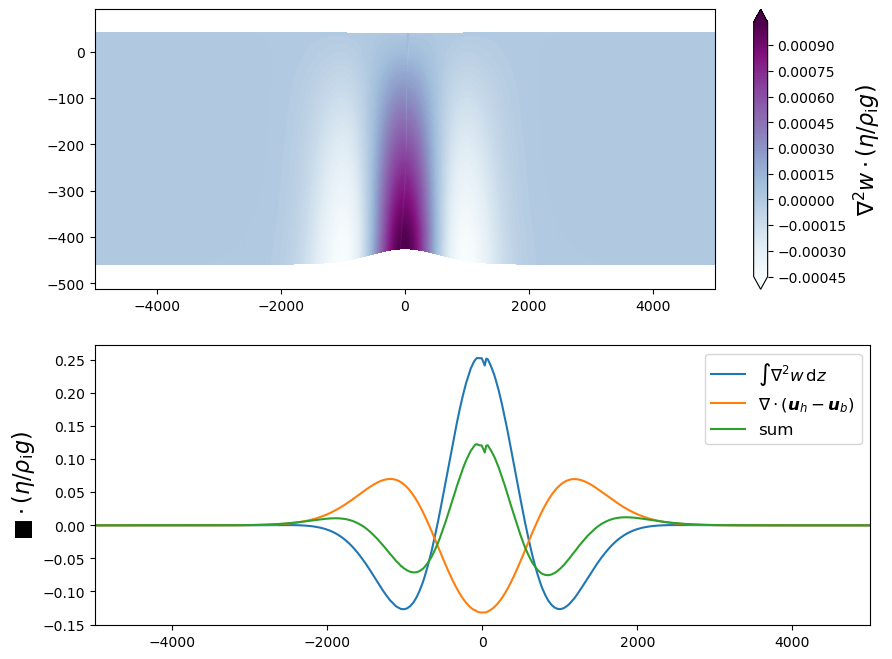

In [17]:
plt.figure(figsize=(10,8))
plt.subplot(211)
# plt.contourf(X,Z,(eta/(rho_i*g))*lapw_interp,cmap='BuPu_r',levels=100,extend='both')
c = plt.tricontourf(triang,(eta/(rho_i*g))*lapw[i],cmap='BuPu',levels=100,extend='both')
# plt.triplot(triang)
plt.ylim(s.min()-pad,h.max()+pad)
plt.xlim(xi.min(),xi.max())
cbar = plt.colorbar(c)
cbar.ax.set_ylabel(r'$\nabla^2 w \cdot (\eta/\rho_\mathrm{i}g)$',fontsize=16)

plt.subplot(212)
plt.plot(xi,lapw_zint*(eta/(rho_i*g)),label=r'$\int\nabla^2 w\,\mathrm{d}z$')
plt.plot(xi,div_diff*(eta/(rho_i*g)),label=r'$\nabla\cdot(\boldsymbol{u}_h-\boldsymbol{u}_b)$')
plt.plot(xi,R_est,label=r'sum')
plt.ylabel(r'$\blacksquare\cdot (\eta/\rho_\mathrm{i}g)$',fontsize=16)
plt.legend(fontsize=12)
plt.xlim(xi.min(),xi.max())
plt.show()
plt.close()

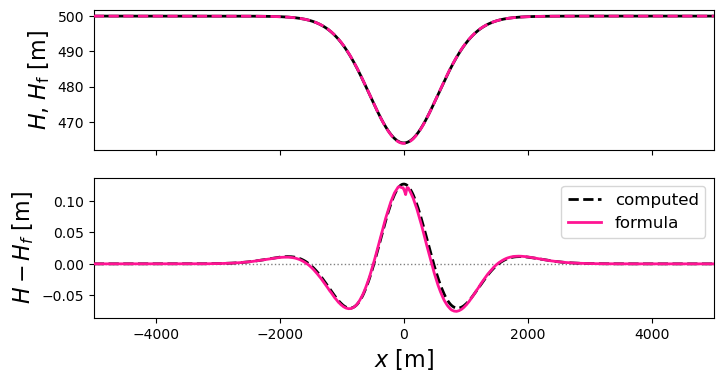

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(211)
plt.plot(xi,H,'k-',linewidth=2,zorder=101)
plt.plot(xi,H_e,'--',color='deeppink',linewidth=2,zorder=101)
plt.ylabel(r'$H$, $H_\mathrm{f}$ [m]',fontsize=16)
plt.xlim(xi.min(),xi.max())
plt.gca().set_xticklabels([])

plt.subplot(212)
R = H-H_e
plt.plot(xi,R-R[0],'k--',linewidth=2,zorder=101,label='computed')
plt.plot(xi,R_est,linestyle='-',color='deeppink',linewidth=2,zorder=101,label='formula')
plt.axhline(y=0,color='k',linestyle=':',linewidth=1,alpha=0.5)
plt.xlabel(r'$x$ [m]',fontsize=16)
plt.ylabel(r'$H - H_f$ [m]',fontsize=16)
plt.xlim(xi.min(),xi.max())
plt.legend(fontsize=12)
plt.show()
plt.close()


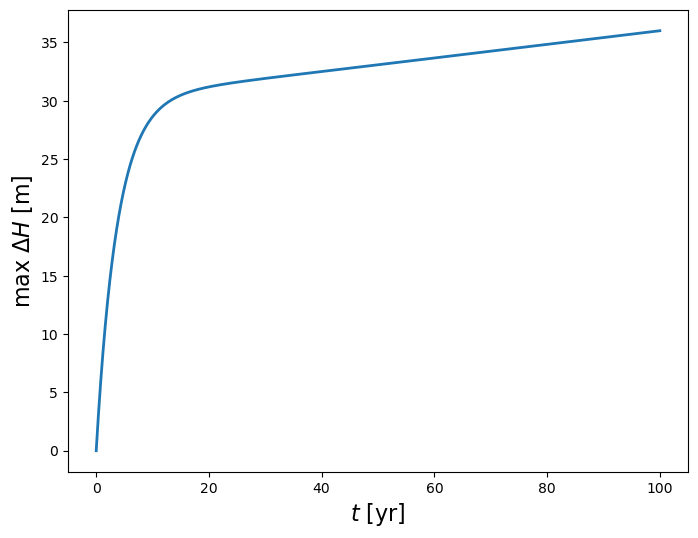

In [19]:
H_ = np.zeros((t.size,xi.size))

for j in range(t.size):
    H_[j] = np.interp(xi, xh[j], h[j])-np.interp(xi, xs[j], s[j])

delta_H = np.max(np.abs(H_-H_[0,0]),axis=1)

plt.figure(figsize=(8,6))
plt.plot(t/3.154e7,delta_H,linewidth=2)
plt.xlabel(r'$t$ [yr]',fontsize=16)
plt.ylabel(r'max $\Delta H$ [m]',fontsize=16)
plt.show()
plt.close()